In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score

# STEP 1: Load data
folder_path = '/content/drive/MyDrive/mediumdataset_csv'
all_patients_data = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df_patient = pd.read_csv(file_path)

        df_patient.rename(columns={
            'Body Temperature': 'temp',
            'Heart Rate': 'hr',
            'Blood Pressure': 'bp',
            'Oxygen Level': 'oxygen'
        }, inplace=True)

        df_patient['Early Heart Failure'] = ((df_patient['bp'] < 100) & (df_patient['hr'] > 100)).astype(int)
        df_patient['Severe Hypoxia'] = (df_patient['oxygen'] < 94).astype(int)
        df_patient['Hyperventilation'] = ((df_patient['hr'] > 95) & (df_patient['oxygen'] > 96)).astype(int)
        df_patient['Postural Hypotension'] = ((df_patient['bp'] < 95) & (df_patient['hr'] < 70)).astype(int)
        df_patient['Mild Infection'] = ((df_patient['temp'] > 37.2) & (df_patient['hr'] < 95)).astype(int)
        df_patient['Viral Fever'] = ((df_patient['temp'] > 38.0) & (df_patient['hr'] > 95)).astype(int)
        df_patient['Chronic Bronchitis'] = ((df_patient['oxygen'] < 93) & (df_patient['temp'] < 37.5)).astype(int)
        df_patient['Cold Exposure'] = (df_patient['temp'] < 36.0).astype(int)
        df_patient['POTS'] = ((df_patient['hr'] > 115) & (df_patient['bp'] > 100)).astype(int)
        df_patient['Allergic Reaction'] = ((df_patient['hr'] > 100) & (df_patient['bp'] > 115) & (df_patient['temp'] > 37)).astype(int)

        all_patients_data.append(df_patient)

# Combine data
df_all = pd.concat(all_patients_data, ignore_index=True)

# Label selection and filtering
label_columns = [
    'Early Heart Failure', 'Severe Hypoxia', 'Hyperventilation', 'Postural Hypotension',
    'Mild Infection', 'Viral Fever', 'Chronic Bronchitis', 'Cold Exposure',
    'POTS', 'Allergic Reaction'
]
label_counts = df_all[label_columns].sum()
keep_labels = label_counts[label_counts > 10].index.tolist()
print("📉 Dropped Rare Labels (<=10 occurrences):", set(label_columns) - set(keep_labels))

# Features & Labels
X = df_all[['temp', 'oxygen', 'bp', 'hr']]
Y = df_all[keep_labels]

# Add 5% noise
noise_ratio = 0.05
for col in Y.columns:
    df_all[col] = df_all[col].apply(lambda x: x if np.random.rand() > noise_ratio else 1 - x)

Y = df_all[keep_labels]

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Model training
model = MultiOutputClassifier(RandomForestClassifier(random_state=42))
model.fit(X_train, Y_train)

# Prediction
Y_pred = model.predict(X_test)

# Evaluation
print("✅ Label Counts After Noise:\n", Y.sum())

overall_accuracy = accuracy_score(Y_test, Y_pred)
print(f"\n✅ Overall Exact Match Accuracy: {overall_accuracy:.2f}")

print("\n📊 Per-Disease Accuracy and F1-Score:")
for i, col in enumerate(Y.columns):
    acc = accuracy_score(Y_test[col], Y_pred[:, i])
    f1 = f1_score(Y_test[col], Y_pred[:, i], zero_division=0)
    print(f"{col}: Accuracy = {acc:.2f} | F1 = {f1:.2f}")

#  Suppress warning by setting zero_division=0
print("\n📋 Full Classification Report (no warnings):")
print(classification_report(Y_test, Y_pred, target_names=Y.columns, zero_division=0))


📉 Dropped Rare Labels (<=10 occurrences): {'POTS', 'Allergic Reaction'}
✅ Label Counts After Noise:
 Early Heart Failure     1013
Severe Hypoxia          5671
Hyperventilation        1792
Postural Hypotension    3964
Mild Infection          4299
Viral Fever              985
Chronic Bronchitis      5424
Cold Exposure           3313
dtype: int64

✅ Overall Exact Match Accuracy: 0.65

📊 Per-Disease Accuracy and F1-Score:
Early Heart Failure: Accuracy = 0.95 | F1 = 0.15
Severe Hypoxia: Accuracy = 0.94 | F1 = 0.90
Hyperventilation: Accuracy = 0.94 | F1 = 0.63
Postural Hypotension: Accuracy = 0.95 | F1 = 0.86
Mild Infection: Accuracy = 0.95 | F1 = 0.88
Viral Fever: Accuracy = 0.95 | F1 = 0.06
Chronic Bronchitis: Accuracy = 0.94 | F1 = 0.89
Cold Exposure: Accuracy = 0.95 | F1 = 0.83

📋 Full Classification Report (no warnings):
                      precision    recall  f1-score   support

 Early Heart Failure       0.50      0.09      0.15       194
      Severe Hypoxia       0.93      0.88  

In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler

# MODELS
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Load all patient files
folder_path = '/content/drive/MyDrive/mediumdataset_csv'
all_patients_data = []

for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df_patient = pd.read_csv(file_path)

        df_patient.rename(columns={
            'Body Temperature': 'temp',
            'Heart Rate': 'hr',
            'Blood Pressure': 'bp',
            'Oxygen Level': 'oxygen'
        }, inplace=True)

        # Rule-based labels
        df_patient['Early Heart Failure'] = ((df_patient['bp'] < 100) & (df_patient['hr'] > 100)).astype(int)
        df_patient['Severe Hypoxia'] = (df_patient['oxygen'] < 94).astype(int)
        df_patient['Hyperventilation'] = ((df_patient['hr'] > 95) & (df_patient['oxygen'] > 96)).astype(int)
        df_patient['Postural Hypotension'] = ((df_patient['bp'] < 95) & (df_patient['hr'] < 70)).astype(int)
        df_patient['Mild Infection'] = ((df_patient['temp'] > 37.2) & (df_patient['hr'] < 95)).astype(int)
        df_patient['Viral Fever'] = ((df_patient['temp'] > 38.0) & (df_patient['hr'] > 95)).astype(int)
        df_patient['Chronic Bronchitis'] = ((df_patient['oxygen'] < 93) & (df_patient['temp'] < 37.5)).astype(int)
        df_patient['Cold Exposure'] = (df_patient['temp'] < 36.0).astype(int)
        df_patient['POTS'] = ((df_patient['hr'] > 115) & (df_patient['bp'] > 100)).astype(int)
        df_patient['Allergic Reaction'] = ((df_patient['hr'] > 100) & (df_patient['bp'] > 115) & (df_patient['temp'] > 37)).astype(int)

        all_patients_data.append(df_patient)

# Combine data
df_all = pd.concat(all_patients_data, ignore_index=True)

# Keep only labels with > 10 occurrences
label_columns = [
    'Early Heart Failure', 'Severe Hypoxia', 'Hyperventilation', 'Postural Hypotension',
    'Mild Infection', 'Viral Fever', 'Chronic Bronchitis', 'Cold Exposure',
    'POTS', 'Allergic Reaction'
]
label_counts = df_all[label_columns].sum()
keep_labels = label_counts[label_counts > 10].index.tolist()

X = df_all[['temp', 'oxygen', 'bp', 'hr']]
Y = df_all[keep_labels]

# Inject 5% noise
noise_ratio = 0.05
for col in Y.columns:
    df_all[col] = df_all[col].apply(lambda x: x if np.random.rand() > noise_ratio else 1 - x)
Y = df_all[keep_labels]

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardize for models like Logistic Regression, SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model dictionary
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier()
}

# Evaluation function
def evaluate_model(Y_true, Y_pred, name):
    print(f"\n Results for: {name}")
    print(f" Overall Accuracy: {accuracy_score(Y_true, Y_pred):.2f}")
    for i, col in enumerate(Y.columns):
        acc = accuracy_score(Y_true[col], Y_pred[:, i])
        f1 = f1_score(Y_true[col], Y_pred[:, i], zero_division=0)
        print(f"{col}: Accuracy = {acc:.2f} | F1 = {f1:.2f}")
    print("\n Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=Y.columns, zero_division=0))

# Train and evaluate all models
for name, base_model in models.items():
    if name in ["Logistic Regression", "SVM"]:  # models that benefit from scaling
        model = MultiOutputClassifier(base_model)
        model.fit(X_train_scaled, Y_train)
        Y_pred = model.predict(X_test_scaled)
    else:
        model = MultiOutputClassifier(base_model)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)

    evaluate_model(Y_test, Y_pred, name)



 Results for: Random Forest
 Overall Accuracy: 0.64
Early Heart Failure: Accuracy = 0.94 | F1 = 0.13
Severe Hypoxia: Accuracy = 0.95 | F1 = 0.91
Hyperventilation: Accuracy = 0.95 | F1 = 0.64
Postural Hypotension: Accuracy = 0.95 | F1 = 0.87
Mild Infection: Accuracy = 0.95 | F1 = 0.87
Viral Fever: Accuracy = 0.94 | F1 = 0.03
Chronic Bronchitis: Accuracy = 0.95 | F1 = 0.91
Cold Exposure: Accuracy = 0.94 | F1 = 0.82

 Classification Report:
                      precision    recall  f1-score   support

 Early Heart Failure       0.46      0.07      0.13       215
      Severe Hypoxia       0.93      0.88      0.91      1128
    Hyperventilation       0.85      0.51      0.64       341
Postural Hypotension       0.93      0.81      0.87       771
      Mild Infection       0.94      0.81      0.87       857
         Viral Fever       0.13      0.01      0.03       204
  Chronic Bronchitis       0.95      0.88      0.91      1085
       Cold Exposure       0.92      0.74      0.82       67

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:53:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:53:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:53:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:53:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:53:23] WARNING: /w


 Results for: XGBoost
 Overall Accuracy: 0.66
Early Heart Failure: Accuracy = 0.95 | F1 = 0.12
Severe Hypoxia: Accuracy = 0.95 | F1 = 0.91
Hyperventilation: Accuracy = 0.95 | F1 = 0.66
Postural Hypotension: Accuracy = 0.95 | F1 = 0.88
Mild Infection: Accuracy = 0.95 | F1 = 0.88
Viral Fever: Accuracy = 0.95 | F1 = 0.00
Chronic Bronchitis: Accuracy = 0.95 | F1 = 0.92
Cold Exposure: Accuracy = 0.95 | F1 = 0.83

 Classification Report:
                      precision    recall  f1-score   support

 Early Heart Failure       0.88      0.07      0.12       215
      Severe Hypoxia       0.95      0.88      0.91      1128
    Hyperventilation       0.91      0.51      0.66       341
Postural Hypotension       0.95      0.82      0.88       771
      Mild Infection       0.95      0.81      0.88       857
         Viral Fever       0.00      0.00      0.00       204
  Chronic Bronchitis       0.96      0.87      0.92      1085
       Cold Exposure       0.95      0.74      0.83       675

   

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:09:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:09:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:09:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:09:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [05:09:57] WARNING: /w


Overall Performance Comparison:
                  Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.641795   0.764003  0.590647  0.646499
1  Logistic Regression  0.419515   0.570409  0.313913  0.368518
2                  SVM  0.557005   0.651810  0.455502  0.515821
3              XGBoost  0.661101   0.817909  0.587724  0.649081
4                  KNN  0.495173   0.721841  0.476183  0.543543
5        Decision Tree  0.433342   0.568894  0.577847  0.572605


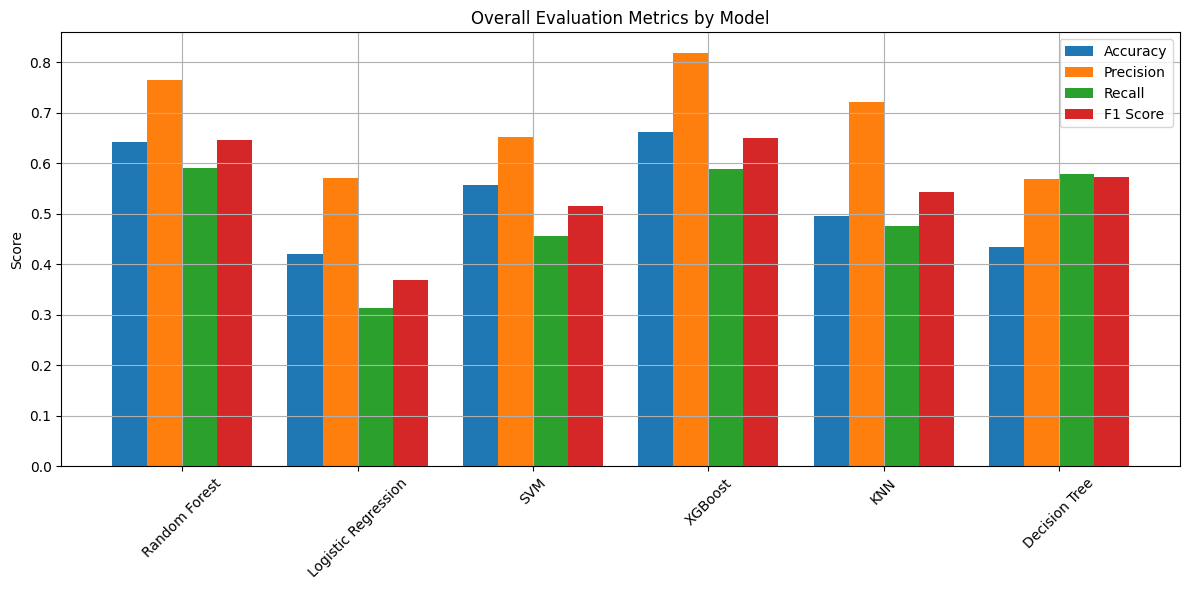

In [ ]:
import matplotlib.pyplot as plt

# Store results
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Reset model loop to collect metrics
for name, base_model in models.items():
    if name in ["Logistic Regression", "SVM"]:
        model = MultiOutputClassifier(base_model)
        model.fit(X_train_scaled, Y_train)
        Y_pred = model.predict(X_test_scaled)
    else:
        model = MultiOutputClassifier(base_model)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='macro', zero_division=0)
    rec = recall_score(Y_test, Y_pred, average='macro', zero_division=0)
    f1 = f1_score(Y_test, Y_pred, average='macro', zero_division=0)

    results["Model"].append(name)
    results["Accuracy"].append(acc)
    results["Precision"].append(prec)
    results["Recall"].append(rec)
    results["F1 Score"].append(f1)

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results)
print("\nOverall Performance Comparison:\n", results_df)

# Plot
plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(results_df))

plt.bar(x - 1.5 * bar_width, results_df["Accuracy"], width=bar_width, label='Accuracy')
plt.bar(x - 0.5 * bar_width, results_df["Precision"], width=bar_width, label='Precision')
plt.bar(x + 0.5 * bar_width, results_df["Recall"], width=bar_width, label='Recall')
plt.bar(x + 1.5 * bar_width, results_df["F1 Score"], width=bar_width, label='F1 Score')

plt.xticks(x, results_df["Model"], rotation=45)
plt.ylabel("Score")
plt.title("Overall Evaluation Metrics by Model")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix


In [ ]:
# ------------------------------
# 10. Plot Confusion Matrices (Per Condition)
# ------------------------------
conf_matrices = multilabel_confusion_matrix(y_test, y_pred_binary)

fig, axes = plt.subplots(5, 2, figsize=(14, 20))
axes = axes.ravel()

for i, (cm, label) in enumerate(zip(conf_matrices, label_columns)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix: {label}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
summary_df = pd.DataFrame({
    'Condition': label_columns,
    'Precision': per_label_precision,
    'Recall': per_label_recall,
    'F1 Score': per_label_f1
})

plt.figure(figsize=(10, 6))
sns.heatmap(summary_df.set_index('Condition'), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("📈 Performance Summary per Health Condition")
plt.show()
